# Ungraded Lab: Building Models for the IMDB Reviews Dataset

## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-07-08 12:54:18.402135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 12:54:18.402233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 12:54:18.514748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and Prepare the Dataset

In [2]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8H37BH/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8H37BH/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8H37BH/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Plot Utility

In [5]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## Model 1: Flatten

In [6]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
102/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5173 - loss: 0.6924

I0000 00:00:1720443344.409410     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720443344.425120     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5539 - loss: 0.6785

W0000 00:00:1720443345.645552     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5544 - loss: 0.6782 - val_accuracy: 0.8258 - val_loss: 0.4039
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8592 - loss: 0.3445 - val_accuracy: 0.8522 - val_loss: 0.3368
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9225 - loss: 0.2203 - val_accuracy: 0.8468 - val_loss: 0.3510
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9640 - loss: 0.1326 - val_accuracy: 0.8387 - val_loss: 0.3836
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0689 - val_accuracy: 0.8357 - val_loss: 0.4232
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0349 - val_accuracy: 0.8314 - val_loss: 0.4755
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0196 - val_accuracy: 0.8317 - val_loss: 0.5028
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0119 - val_accuracy: 0.8307 - val_

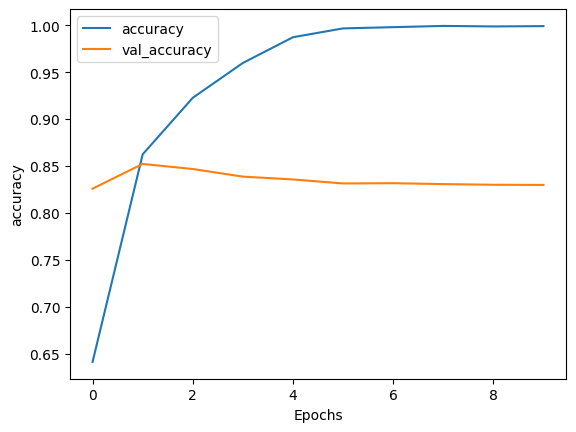

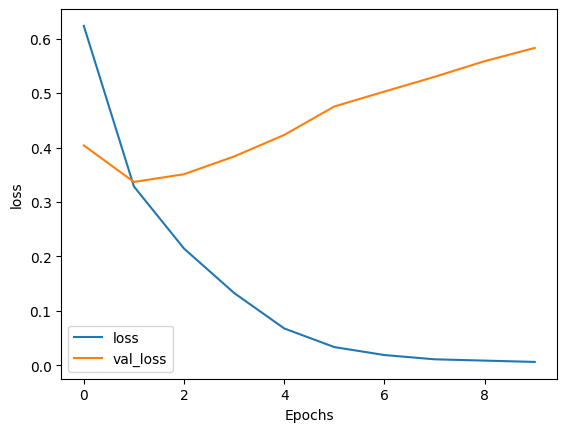

In [8]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

In [9]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6095 - loss: 0.6299 - val_accuracy: 0.8423 - val_loss: 0.3693
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8776 - loss: 0.3087 - val_accuracy: 0.8490 - val_loss: 0.3509
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9104 - loss: 0.2381 - val_accuracy: 0.8442 - val_loss: 0.3708
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9318 - loss: 0.1893 - val_accuracy: 0.8351 - val_loss: 0.4139
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9413 - loss: 0.1634 - val_accuracy: 0.8342 - val_loss: 0.4161
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9502 - loss: 0.1475 - val_accuracy: 0.8250 - val_loss: 0.4915
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9626 - loss: 0.1170 - val_accuracy: 0.8236 - val_loss: 0.5365
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9709 - loss: 0.0933 - val_accu

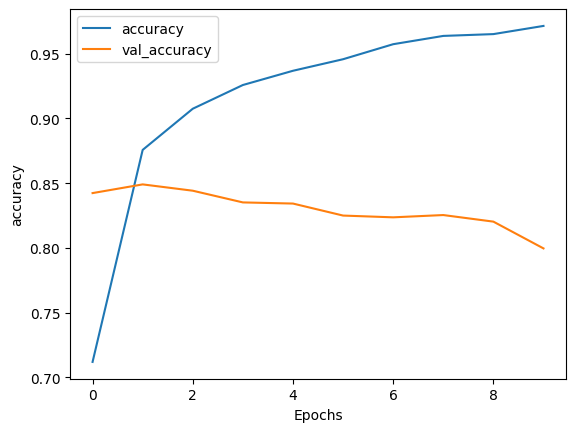

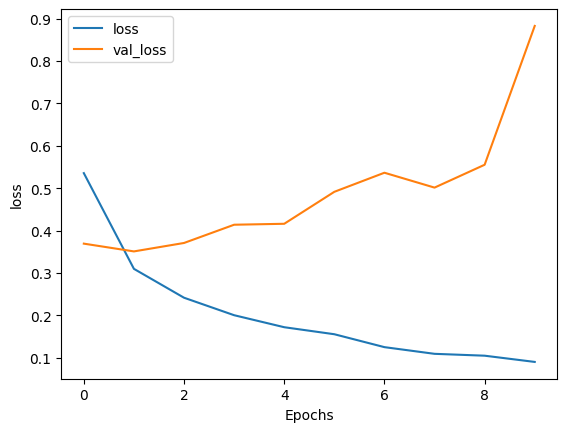

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

In [12]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5324 - loss: 0.6796 - val_accuracy: 0.8040 - val_loss: 0.4839
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8384 - loss: 0.3901 - val_accuracy: 0.8410 - val_loss: 0.3617
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8912 - loss: 0.2756 - val_accuracy: 0.8491 - val_loss: 0.3459
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9221 - loss: 0.2094 - val_accuracy: 0.8383 - val_loss: 0.3953
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9263 - loss: 0.1947 - val_accuracy: 0.8328 - val_loss: 0.4266
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9481 - loss: 0.1450 - val_accuracy: 0.8256 - val_loss: 0.4260
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9612 - loss: 0.1162 - val_accuracy: 0.8299 - val_loss: 0.5764
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9689 - loss: 0.0876 - val_accu

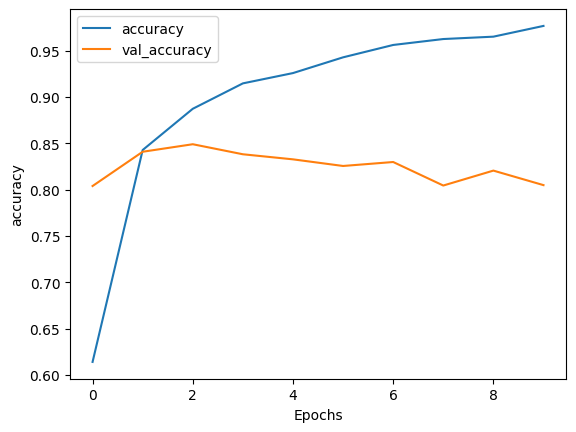

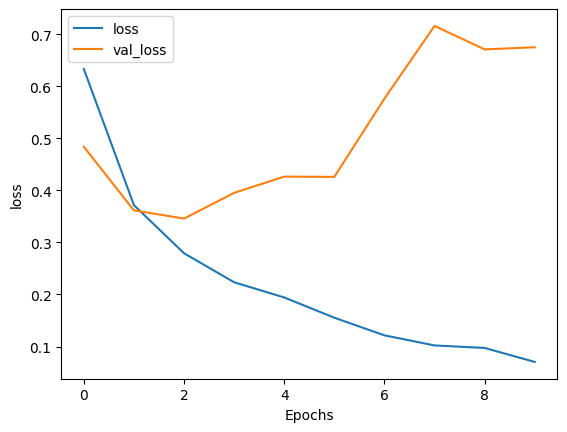

In [14]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

In [15]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5498 - loss: 0.6778 - val_accuracy: 0.8241 - val_loss: 0.4100
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8472 - loss: 0.3605 - val_accuracy: 0.8476 - val_loss: 0.3470
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8877 - loss: 0.2767 - val_accuracy: 0.8464 - val_loss: 0.3525
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9083 - loss: 0.2356 - val_accuracy: 0.8460 - val_loss: 0.3655
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9254 - loss: 0.1978 - val_accuracy: 0.8382 - val_loss: 0.3944
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9320 - loss: 0.1808 - val_accuracy: 0.8350 - val_loss: 0.4263
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9453 - loss: 0.1589 - val_accuracy: 0.8303 - val_loss: 0.4610
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9497 - loss: 0.1404 - val_accuracy: 0

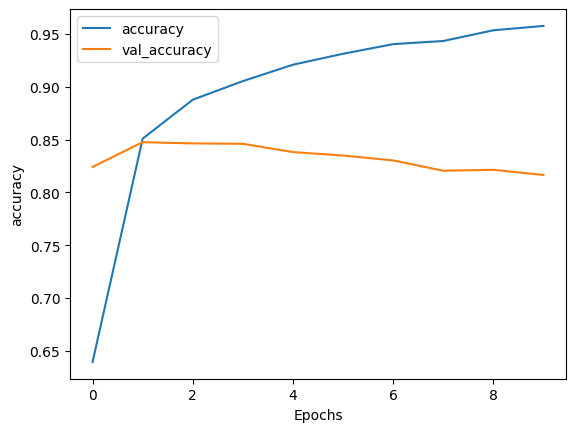

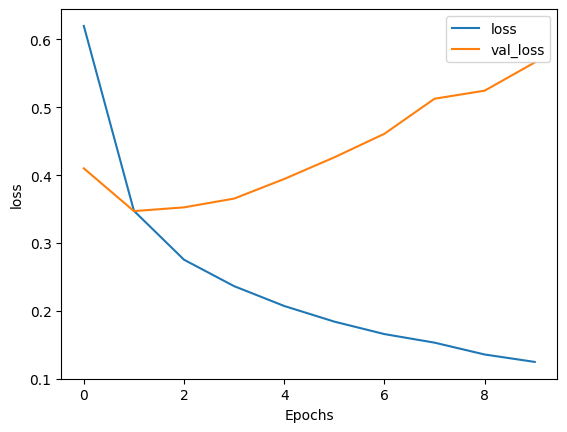

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')